# ***Loading up libraries and data set***

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/freelance/Oscar Hoole/(duplicate( DRIP April - April.csv")

# **EDA**

In [ ]:
data.head()

,urn,copy,type,numViews,numLikes,numComments,numShares,engagementRate,numEmojies,numHashtags,numLinks,hashtags,labels,createdAt
0,urn:li:activity:7188859252755640320,"We've worked on all kinds of pages - blogs, e-...",Text,2329,14,18,0,1.37%,0,0,0,NaN,NaN,2024-04-24 14:28:01
1,urn:li:activity:7188051799130415104,Not every test is a winner. But the insights a...,Document,4401,26,10,0,0.82%,1,0,0,NaN,NaN,2024-04-22 9:08:43
2,urn:li:activity:7187742117262209024,Adding more social proof to your website can b...,Image,4522,45,6,0,1.13%,1,0,0,NaN,NaN,2024-04-21 12:22:42
3,urn:li:activity:7187381371965689856,The majority of A/B tests fail... \n\nCould kn...,Text,4615,42,5,0,1.02%,0,2,0,"1,2",NaN,2024-04-20 12:40:15
4,urn:li:activity:7186692499623620608,You'll want to try this product bundling strat...,Document,4059,27,2,0,0.71%,0,0,0,NaN,NaN,2024-04-18 14:59:37


In [ ]:
data.describe()

,numViews,numLikes,numComments,numShares,numEmojies,numHashtags,numLinks,labels
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.0,0.0
mean,6541.176471,37.352941,13.941176,0.235294,0.176471,1.352941,0.0,NaN
std,3195.592399,19.662595,18.709859,0.664211,0.392953,1.271868,0.0,NaN
min,2329.000000,5.000000,2.000000,0.000000,0.000000,0.000000,0.0,NaN
25%,4522.000000,26.000000,4.000000,0.000000,0.000000,0.000000,0.0,NaN
50%,6183.000000,37.000000,8.000000,0.000000,0.000000,2.000000,0.0,NaN
75%,8089.000000,45.000000,18.000000,0.000000,0.000000,2.000000,0.0,NaN
max,16010.000000,75.000000,80.000000,2.000000,1.000000,4.000000,0.0,NaN


In [ ]:
print(data.dtypes)

urn                object
copy               object
type               object
numViews            int64
numLikes            int64
numComments         int64
numShares           int64
engagementRate     object
numEmojies          int64
numHashtags         int64
numLinks            int64
hashtags           object
labels            float64
createdAt          object
dtype: object


In [ ]:
print(data.isnull().sum())

urn                0
copy               0
type               0
numViews           0
numLikes           0
numComments        0
numShares          0
engagementRate     0
numEmojies         0
numHashtags        0
numLinks           0
hashtags           7
labels            17
createdAt          0
dtype: int64


# **Pre-Processing**

In [ ]:
data["hashtags"] = data["hashtags"].fillna("")

In [ ]:
data.drop('labels', axis=1, inplace=True)

In [ ]:
data["character_count"] = data["copy"].str.len()

In [ ]:
print("Sample data with character count:")
print(data[["copy", "character_count"]].head())

Sample data with character count:
                                                copy  character_count
0  We've worked on all kinds of pages - blogs, e-...             1046
1  Not every test is a winner. But the insights a...             1603
2  Adding more social proof to your website can b...             1401
3  The majority of A/B tests fail... \n\nCould kn...             1365
4  You'll want to try this product bundling strat...             1600


# **Analysis**

In [ ]:
print(data[["character_count", "numViews"]].describe())

       character_count      numViews
count        17.000000     17.000000
mean       1142.764706   6541.176471
std         386.473565   3195.592399
min         451.000000   2329.000000
25%         876.000000   4522.000000
50%        1165.000000   6183.000000
75%        1401.000000   8089.000000
max        1666.000000  16010.000000


## Correlation analysis

In [ ]:
data["engagement_ratio"] = (data["numComments"] + data["numLikes"] + data["numShares"]) / data["numViews"]

                  character_count  engagement_ratio
character_count          1.000000          0.201812
engagement_ratio         0.201812          1.000000


<Figure size 1000x600 with 0 Axes>

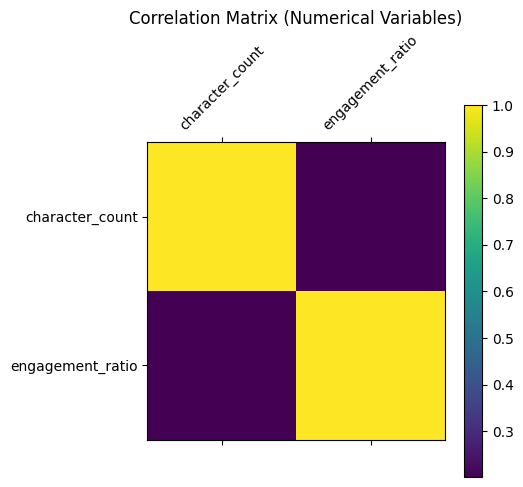

In [ ]:
relevant_columns = ["character_count","engagement_ratio"]
correlation_matrix = data[relevant_columns].corr()

# Display the correlation matrix
print(correlation_matrix.to_string())
plt.figure(figsize=(10, 6))
ax = plt.matshow(correlation_matrix)
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.colorbar()
plt.title("Correlation Matrix (Numerical Variables)")
plt.show()


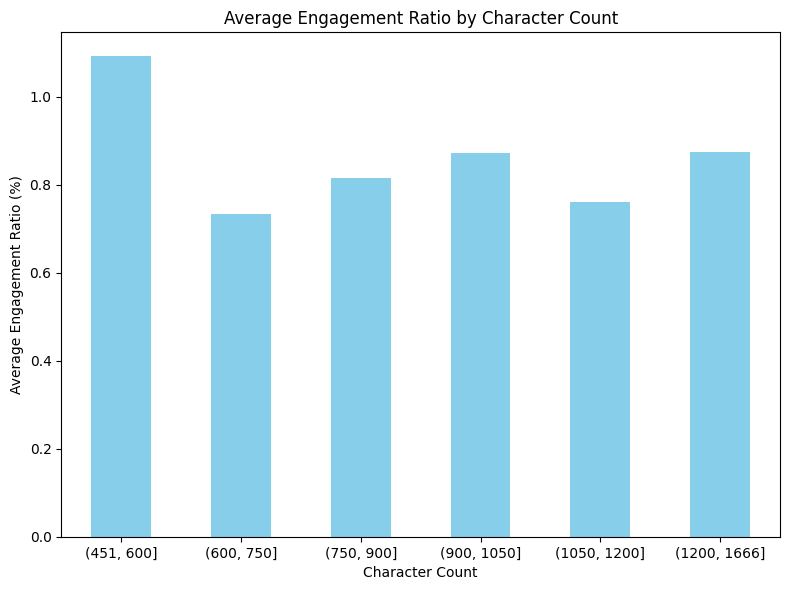

In [ ]:
# Define character count bins (adjust bin sizes as needed)
bins = [451, 600, 750, 900, 1050, 1200, 1666]

# Function to calculate average impressions by group (reusable)
def avg_impressions_by_group(data, group_by_col):
  """
  Calculates average impressions for groups in a DataFrame.

  Args:
      data: The DataFrame containing the data.
      group_by_col: The column to group the data by.

  Returns:
      A Series containing the average impressions for each group.
  """
  return data.groupby(group_by_col)["engagement_ratio"].mean()


# A. Distribution by Character Count
data_grouped_char_count = avg_impressions_by_group(data.copy(), pd.cut(data["copy"].str.len(), bins=bins))

# Visualization for character count distribution
plt.figure(figsize=(8, 6))
data_grouped_char_count = data_grouped_char_count * 100  # Convert engagement ratio to percentage
data_grouped_char_count.plot(kind="bar", color="skyblue")
plt.xlabel("Character Count")
plt.ylabel("Average Engagement Ratio (%)")  # Update label with percentage
plt.title("Average Engagement Ratio by Character Count")
plt.xticks(rotation=0)  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()


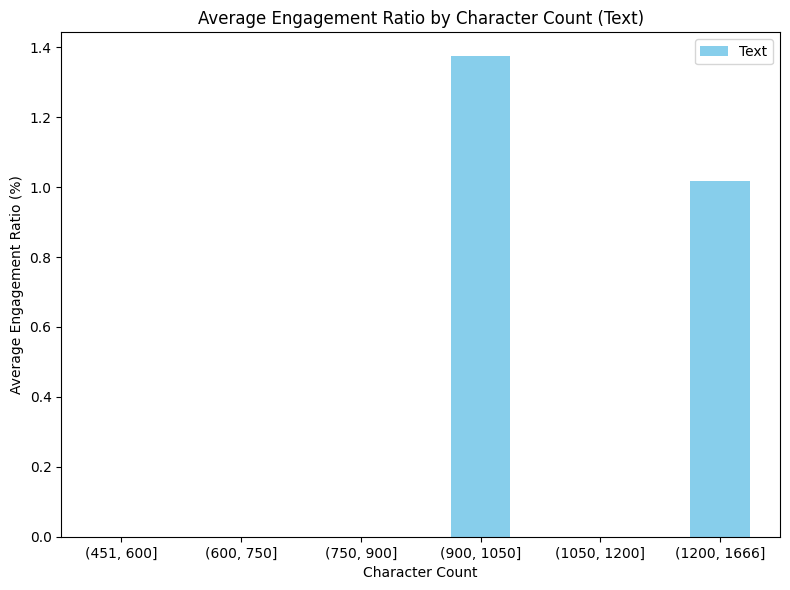

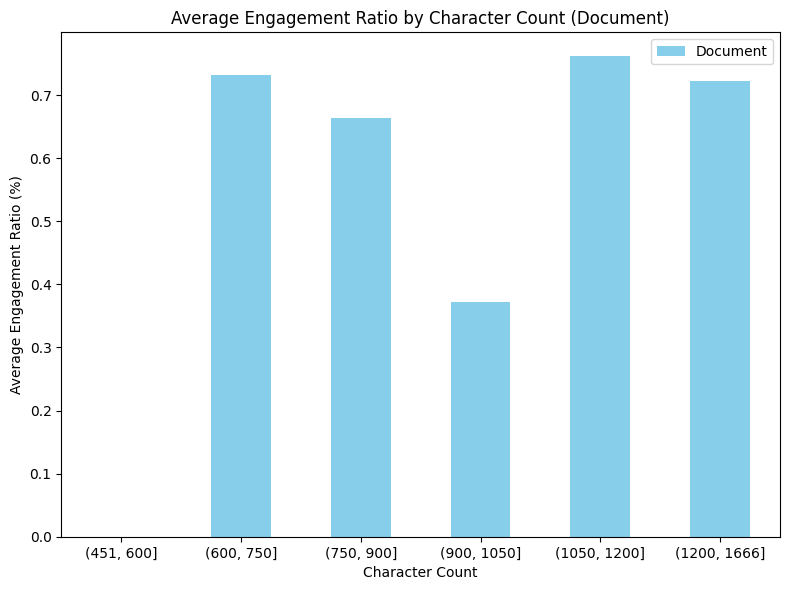

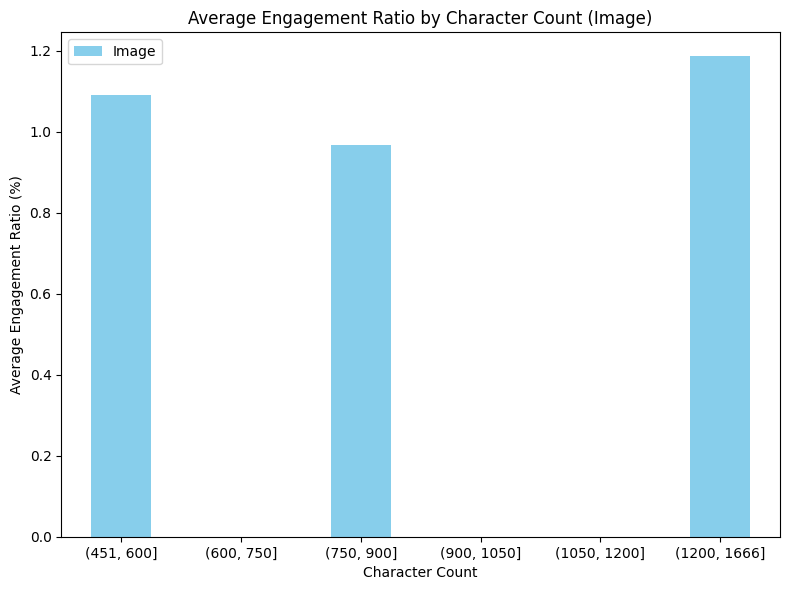

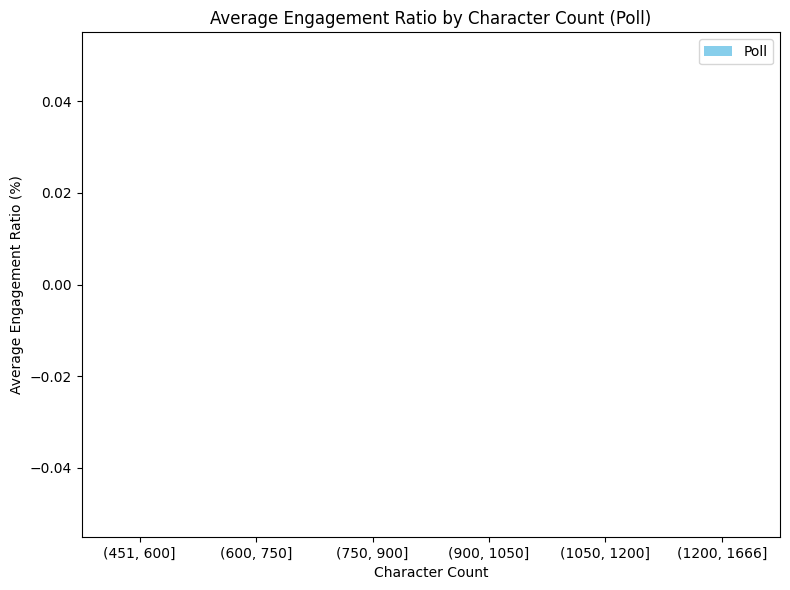

In [ ]:
if "type" in data.columns:
  # Group data by post type
  post_types = data["type"].unique()

  # Analyze by post type (looping through each type)
  for post_type in post_types:
    content_data = data.query("type == @post_type")
    data_grouped_char_count_content_type = avg_impressions_by_group(content_data.copy(), pd.cut(content_data["copy"].str.len(), bins=bins))
    data_grouped_char_count_content_type = data_grouped_char_count_content_type * 100  # Convert engagement ratio to percentage

    # Visualization for each post type (assuming multiple plots)
    plt.figure(figsize=(8, 6))
    data_grouped_char_count_content_type.plot(kind="bar", color="skyblue", label=post_type)
    plt.xlabel("Character Count")
    plt.ylabel("Average Engagement Ratio (%)")  # Update label with percentage
    plt.title(f"Average Engagement Ratio by Character Count ({post_type})")
    plt.xticks(rotation=0)
    plt.legend()
    plt.tight_layout()
    plt.show()

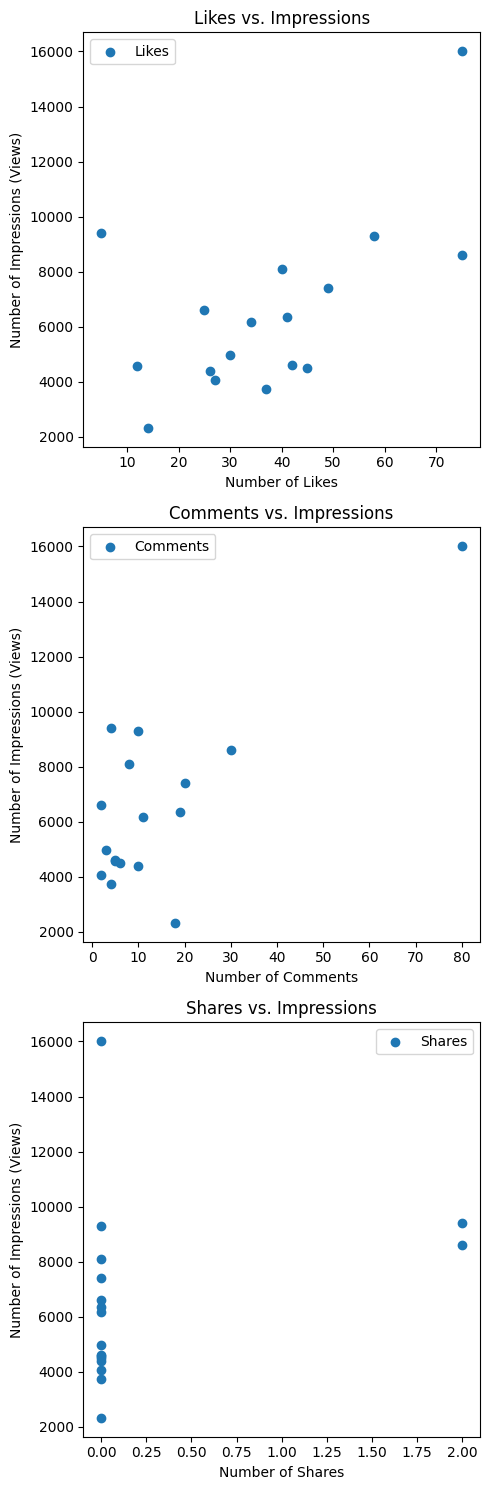

In [ ]:
plt.figure(figsize=(5, 15))

# Scatter plot for Likes (top)
plt.subplot(3, 1, 1)  # Create subplot for first plot (3 rows, 1 column, position 1)
plt.scatter(data["numLikes"], data["numViews"], label="Likes")
plt.xlabel("Number of Likes")
plt.ylabel("Number of Impressions (Views)")
plt.title("Likes vs. Impressions")
plt.legend()

# Scatter plot for Comments (middle)
plt.subplot(3, 1, 2)  # Create subplot for second plot (position 2)
plt.scatter(data["numComments"], data["numViews"], label="Comments")
plt.xlabel("Number of Comments")
plt.ylabel("Number of Impressions (Views)")
plt.title("Comments vs. Impressions")
plt.legend()

# Scatter plot for Shares (bottom)
plt.subplot(3, 1, 3)  # Create subplot for third plot (position 3)
plt.scatter(data["numShares"], data["numViews"], label="Shares")
plt.xlabel("Number of Shares")
plt.ylabel("Number of Impressions (Views)")
plt.title("Shares vs. Impressions")
plt.legend()

plt.tight_layout()  # Adjust spacing between subplots for better readability
plt.show()

In [ ]:
def calculate_weighted_score(data, weight_char_count=0.6, weight_post_type=0.4):
  """
  Calculates a weighted score for each post based on engagement by character count and post type,
  and adds it as a new column named "post_score".

  Args:
      data: The DataFrame containing the data (modified in place).
      weight_char_count: Weight for engagement by character count (default: 0.6).
      weight_post_type: Weight for engagement by post type (default: 0.4).

  Returns:
      The modified DataFrame with a new "post_score" column (scaled to 1-100).
  """

  # Group by post type (assuming data has a "type" column)
  post_types = data["type"].unique()
  data_grouped = data.groupby("type")

  # Calculate average engagement ratio by character count for each post type
  avg_engagement_char_count = data_grouped["engagement_ratio"].mean()

  # Merge engagement ratios back to original data
  data = data.merge(avg_engagement_char_count.to_frame(name="avg_engagement_char_count").reset_index(), on="type", how="left")

  # Calculate weighted score directly using engagement ratio (already normalized)
  data["post_score"] = (data["engagement_ratio"] * weight_char_count) + (data["avg_engagement_char_count"] * weight_post_type)

  # Scale score to 1-100 (assuming scores can be negative or positive)
  min_score = data["post_score"].min()
  max_score = data["post_score"].max()
  data["post_score"] = (data["post_score"] - min_score) / (max_score - min_score) * 100

  return data

In [ ]:
data = calculate_weighted_score(data)
data.head()

,urn,copy,type,numViews,numLikes,numComments,numShares,engagementRate,numEmojies,numHashtags,numLinks,hashtags,createdAt,character_count,engagement_ratio,avg_engagement_char_count,post_score
0,urn:li:activity:7188859252755640320,"We've worked on all kinds of pages - blogs, e-...",Text,2329,14,18,0,1.37%,0,0,0,,2024-04-24 14:28:01,1046,0.013740,0.011962,100.000000
1,urn:li:activity:7188051799130415104,Not every test is a winner. But the insights a...,Document,4401,26,10,0,0.82%,1,0,0,,2024-04-22 9:08:43,1603,0.008180,0.006904,54.812919
2,urn:li:activity:7187742117262209024,Adding more social proof to your website can b...,Image,4522,45,6,0,1.13%,1,0,0,,2024-04-21 12:22:42,1401,0.011278,0.011081,84.574780
3,urn:li:activity:7187381371965689856,The majority of A/B tests fail... \n\nCould kn...,Text,4615,42,5,0,1.02%,0,2,0,"1,2",2024-04-20 12:40:15,1365,0.010184,0.011962,82.012162
4,urn:li:activity:7186692499623620608,You'll want to try this product bundling strat...,Document,4059,27,2,0,0.71%,0,0,0,,2024-04-18 14:59:37,1600,0.007145,0.006904,49.575136


# **keyword analysis**

In [ ]:
# Calculate the maximum engagement ratio
max_engagement_ratio = data["engagement_ratio"].max()

# Set the engagement threshold at half of the maximum
engagement_threshold = max_engagement_ratio / 2

# Filter data based on the threshold
high_engagement_data = data[data["engagement_ratio"] >= engagement_threshold]
low_engagement_data = data[data["engagement_ratio"] < engagement_threshold]


In [ ]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
  text = text.lower()

  # Remove punctuation
  import string
  punctuation = set(string.punctuation)
  text = ''.join([char for char in text if char not in punctuation])

  # Remove stop words
  tokens = word_tokenize(text)
  filtered_words = [word for word in tokens if word not in stop_words]

  return " ".join(filtered_words)

In [ ]:
data["copy"] = data["copy"].apply(preprocess_text)

In [ ]:
# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=100)  # Adjust max_features as needed

# Fit the vectorizer on the preprocessed post content
text_data = data["copy"]
vectorizer.fit(text_data)

# Get the feature names (keywords)
feature_names = vectorizer.get_feature_names_out()

# Get TF-IDF matrix
tfidf_matrix = vectorizer.transform(text_data)


# Get document-term matrix
document_terms = tfidf_matrix.toarray()

In [ ]:
# Extract top N keywords based on TF-IDF scores
top_n_keywords = 10  # Adjust as needed
top_keywords = [(feature_names[i], document_terms[:, i].max()) for i in document_terms.argmax(axis=0)[:top_n_keywords]]

In [ ]:
# Print top keywords and their TF-IDF scores
print("Top", top_n_keywords, "Keywords:")
for keyword, score in top_keywords:
  print(f"- {keyword} (TF-IDF Score: {score:.4f})")

Top 10 Keywords:
- could (TF-IDF Score: 0.3063)
- arpu (TF-IDF Score: 0.1681)
- conducted (TF-IDF Score: 0.1153)
- arpu (TF-IDF Score: 0.1681)
- cognitive (TF-IDF Score: 0.1310)
- arpu (TF-IDF Score: 0.1681)
- already (TF-IDF Score: 0.4616)
- cognitive (TF-IDF Score: 0.1310)
- customers (TF-IDF Score: 0.5589)
- ab (TF-IDF Score: 0.1746)


# **Sentiment Analysis**

In [ ]:
post_content = data["copy"]

In [ ]:
def analyze_sentiment(text):
  """
  Performs sentiment analysis using TextBlob.

  Args:
      text: The text to analyze.

  Returns:
      A tuple (sentiment score, subjectivity score).
  """
  textblob_object = TextBlob(text)
  sentiment = textblob_object.sentiment.polarity
  # Scale sentiment score to 0-100 (assuming polarity ranges from -1 to 1)
  sentiment_score = (sentiment + 1) * 50  # Adjust factors for your desired range

  return sentiment_score, textblob_object.sentiment.subjectivity

sentiment_data = []
for text in data["copy"]:
  # Preprocess text
  text = text.lower()  # Lowercase for consistency

  # Handle missing values or empty strings
  sentiment_score = 0.0
  subjectivity_score = 0.0
  sentiment_label = "Unknown"  # Assign a default label
else:
  # Perform sentiment analysis
  sentiment_score, subjectivity_score = analyze_sentiment(text)

  # Assign sentiment label based on score
  if sentiment_score > 0.0:
    sentiment_label = "Positive"
  elif sentiment_score < 0.0:
     sentiment_label = "Negative"
  else:
     sentiment_label = "Neutral"

  sentiment_data.append((sentiment_score, subjectivity_score, sentiment_label))
  sentiment_data.append((sentiment_score, subjectivity_score, sentiment_label))
  print(f"Length of sentiment_data: {len(sentiment_data)}")

# Add sentiment score and label columns to DataFrame (check length for safety)
if len(sentiment_data) == len(data):
  data["sentiment_score"] = [score[0] for score in sentiment_data]
  data["sentiment_label"] = [score[2] for score in sentiment_data]
else:
  print("Warning: Length mismatch between sentiment data and DataFrame. Skipping adding sentiment columns.")

print("Sentiment analysis complete. New columns added: sentiment_score, sentiment_label")

Length of sentiment_data: 2
Sentiment analysis complete. New columns added: sentiment_score, sentiment_label


In [ ]:
data.head()

,urn,copy,type,numViews,numLikes,numComments,numShares,engagementRate,numEmojies,numHashtags,numLinks,hashtags,createdAt,character_count,engagement_ratio,avg_engagement_char_count,post_score
0,urn:li:activity:7188859252755640320,weve worked kinds pages blogs ecommerce stores...,Text,2329,14,18,0,1.37%,0,0,0,,2024-04-24 14:28:01,1046,0.013740,0.011962,100.000000
1,urn:li:activity:7188051799130415104,every test winner insights priceless marketers...,Document,4401,26,10,0,0.82%,1,0,0,,2024-04-22 9:08:43,1603,0.008180,0.006904,54.812919
2,urn:li:activity:7187742117262209024,adding social proof website complete failure r...,Image,4522,45,6,0,1.13%,1,0,0,,2024-04-21 12:22:42,1401,0.011278,0.011081,84.574780
3,urn:li:activity:7187381371965689856,majority ab tests fail could knowing say test ...,Text,4615,42,5,0,1.02%,0,2,0,"1,2",2024-04-20 12:40:15,1365,0.010184,0.011962,82.012162
4,urn:li:activity:7186692499623620608,youll want try product bundling strategy seein...,Document,4059,27,2,0,0.71%,0,0,0,,2024-04-18 14:59:37,1600,0.007145,0.006904,49.575136


In [ ]:
data.to_csv('socialmedia_analysis.csv', index=False)